# Imports

In [5]:
import argparse
import os
import copy
import numpy as np
from PIL import Image
import matplotlib. pyplot as plt 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import time
import tensorflow as tf
import mlflow
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

# Model

In [5]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor):

        super(FSRCNN, self).__init__()
        self.scale_factor = scale_factor

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 56, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, kernel_size=1),
            nn.PReLU()
        )
        self.non_linear_mapping = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, kernel_size=1),
            nn.PReLU()
        )
        self.deconvolution = nn.ConvTranspose2d(56, 3, kernel_size=9, stride=scale_factor, padding=4, output_padding=scale_factor-1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.non_linear_mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)
        return x


# Dataloader / preprocessing

In [6]:
class DIV2KDataset(Dataset):
    def __init__(self, img_dir, scale_factor, desired_height, desired_width):
        super(DIV2KDataset, self).__init__()
        self.img_dir = img_dir
        self.scale_factor = scale_factor
        self.desired_height = desired_height
        self.desired_width = desired_width
        self.img_list = os.listdir(self.img_dir)

    def __getitem__(self, index):
        img_hr = Image.open(os.path.join(self.img_dir, self.img_list[index]))

        # Resize image to the desired width and length
        img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)

        # Resize low resolution image according to the scale factor
        img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)

        transform = T.Compose([
            # Convert image to tensor
            T.ToTensor(),
            # Compose other transformtion if necessary
        ])

        img_hr = transform(img_hr)
        img_lr = transform(img_lr)

        return img_hr, img_lr

    def __len__(self):
        return len(self.img_list)


# Training and Validation

In [7]:
class TrainFSRCNN(object):
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, n_epochs, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_epochs = n_epochs
        self.device = device
        self.log_dir = '/phoenix/tensorboard/tensorlogs'
        self.mlflow_exp_name = 'super_resolution'
        self.tb_writer = torch.utils.tensorboard.SummaryWriter()
        self.best_metric = float('inf')  
        self.best_epoch = -1

    def train(self):
        # Add timer to measure training time
        start_time = time.time()

        writer = SummaryWriter(self.log_dir)
        mlflow.set_experiment(self.mlflow_exp_name)

        self.model = self.model.to(self.device)
        self.model.train()

        outer_loop = tqdm(range(self.n_epochs))

        for epoch in outer_loop:
        # for epoch in range(self.n_epochs):
            running_loss = 0.0
            outer_loop.set_description(f"Epoch [{epoch}/{self.n_epochs}]")
            for i, (hr, lr) in tqdm(enumerate(self.train_loader)):
                hr = hr.to(self.device)
                lr = lr.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            if (epoch) % 10 == 0:
            # if epoch == 1:
                # Write on tensorboard every 10 epochs
                self.log_images_to_tensorboard(writer, epoch)

            # Validate on the validation set
            val_loss, val_psnr = self.validate()

            # Print statistics
            print("Epoch: %d, Loss: %.3f, Validation Loss: %.3f, Validation PSNR: %.2f" %
                  (epoch + 1, running_loss / len(self.train_loader), val_loss, val_psnr))
            
            if running_loss < self.best_metric:
                torch.save(self.model.state_dict(), 'best_model.pth')
                best_metric = running_loss
    

        writer.close()

        with mlflow.start_run(run_name="fscnn_main") as run:
            print(run.info.run_id)
            mlflow.log_metric("Training RMSE", running_loss)
            mlflow.log_metric("Validation RMSE", val_loss)
            mlflow.log_metric("Validation PSNR", val_psnr)
            mlflow.register_model(model_uri = f"runs:/{run.info.run_id}/fscnn", name="fscnn")

        # Add a timer to calculate the training time
        end_time = time.time()
        total_time = end_time - start_time
        print('Total time of training: {:.2f} seconds'.format(total_time))

    def log_images_to_tensorboard(self, writer, epoch):
        self.model.eval()

        with torch.no_grad():
            # Get a batch from the validation set
            hr, lr = next(iter(self.val_loader))
            hr = hr.to(self.device)
            lr = lr.to(self.device)

            # Forward pass
            outputs = self.model(lr)

            # Convert images to a grid for visualization
            grid_hr = make_grid(hr, nrow=1, normalize=True)
            grid_lr = make_grid(lr, nrow=1, normalize=True)
            grid_sr = make_grid(outputs, nrow=1, normalize=True)

            # Log images to TensorBoard
            writer.add_image(f'Original/Epoch_{epoch + 1}', grid_hr, epoch)
            writer.add_image(f'Low Resolution/Epoch_{epoch + 1}', grid_lr, epoch)
            writer.add_image(f'Super-Resolved/Epoch_{epoch + 1}', grid_sr, epoch)

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_psnr = 0.0
            val_loop = tqdm(self.val_loader)
            count = 0
            for hr, lr in self.val_loader:
                hr = hr.to(self.device)
                lr = lr.to(self.device)
                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                val_loss += loss.item()

                # Calculate PSNR
                mse = torch.mean((hr - outputs) ** 2)
                psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
                val_psnr += psnr.item()
                count += 1
                val_loop.set_description(f"Validation: Loss = {val_loss / count}")
            val_loop.close()
            return val_loss / len(self.val_loader), val_psnr / len(self.val_loader)

    def device_validate(self):
        self.model = self.model.to(self.device)
        return self.validate()


In [8]:
class Args:
    train_dir = '/home/jovyan/datafabric/DIV2K/DIV2K_train_HR/'
    val_dir = '/home/jovyan/datafabric/DIV2K/DIV2K_valid_HR/'  
    scale = 4
    batch_size = 4
    epochs = 4

args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mlflow.set_experiment("Super Resolution 4x")

# Load training dataset
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Load validation dataset
val_dataset = DIV2KDataset(args.val_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

model = FSRCNN(scale_factor=args.scale)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_fsrcnn = TrainFSRCNN(model, criterion, optimizer, train_loader, val_loader, args.epochs, device)

train_fsrcnn.train()


2025/03/13 11:12:56 INFO mlflow.tracking.fluent: Experiment with name 'super_resolution' does not exist. Creating a new experiment.


cpu


  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.298, Validation Loss: 0.267, Validation PSNR: 5.94


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.253, Validation Loss: 0.227, Validation PSNR: 6.66


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.211, Validation Loss: 0.183, Validation PSNR: 7.53


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.128, Validation Loss: 0.060, Validation PSNR: 12.25
de234e3a6bff49e289a3092158115942
Total time of training: 1249.31 seconds


Successfully registered model 'fscnn'.
Created version '1' of model 'fscnn'.


# Inference

In [9]:
torch.save(model.state_dict(), 'FSRCNN_300_epochs.pt')

/tmp/ipykernel_197/3920952098.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FSRCNN_300_epochs.pt'))
Clipping input data to the valid 

PREDICTED image torch.Size([3, 1020, 2040])
High Resolution Image torch.Size([3, 1020, 2040])


(-0.5, 2039.5, 1019.5, -0.5)

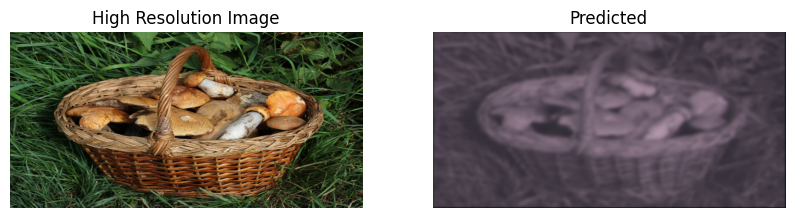

In [10]:
model = FSRCNN(4)
model.to(device)
model.load_state_dict(torch.load('FSRCNN_300_epochs.pt'))
model.eval()

x_batch, y_batch = next(iter(val_loader))
y, x = x_batch[0], y_batch[0]
x = x.to(device)
pred = model(x)
pred = pred.cpu()
print('PREDICTED image', pred.shape)
print('High Resolution Image', y.shape)

# Convert tensors to numpy arrays 
y = y.numpy().transpose(1, 2, 0)
pred = pred.detach().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title('High Resolution Image')
axes[0].axis('off')

axes[1].imshow(pred)
axes[1].set_title('Predicted')
axes[1].axis('off')


# HR and LR image comparasion

High Resolution image torch.Size([1020, 2040, 3])
Low Resolution image torch.Size([255, 510, 3])


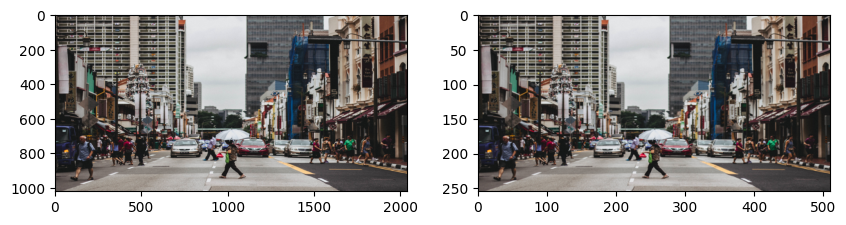

In [11]:
def train_imgs_visualization():
    for imgs in train_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        print('High Resolution image', img1.shape)

        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        print('Low Resolution image', img2.shape)
        break

def val_imgs_visualization():
    for imgs in val_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        break

train_imgs_visualization()